# __Back of the Battery Calculator__
---
# __3. The Cell Stack__

#### Copyright © Intercalation Ltd. All rights reserved.

<div>
<img src="images/fig_botb.png" width="800">
</div>




In the third episode of our Back of the Battery Calculator series, we're speccing out and assembling the other layers of our battery cell "stack". Last time we defined the properties that make up the electrode active material and electrode composite:

```
Cell
    - Electrode (+)
        - Electrode composite (+)
            - Active material (+)
        - Current collector (+)
    - Electrode (-)
        - Electrode composite (-)
            - Active material (-)
        - Current collector (-)
    - Separator
    - Electrolyte
```

Now we need to look at the current collectors, separator, and electrolyte too. 

Make sure you support Intercalation Station by hitting that ***[subscribe!](https://intercalationstation.substack.com/subscribe)***

---
## BotB Plan
1. Theoretical capacities [[link]](https://intercalationstation.substack.com/p/botb-1-introduction-and-capacity)
2. Active materials [[link]](https://intercalationstation.substack.com/p/botb-2-active-materials-and-electrodes)
3. Cell sandwich layers
4. Winding a cylindrical cell
5. Stacking a pouch cell
6. Prismatic cells
7. tbd
---

## Outline for BotB 3:
* A) Recap: defining a cathode and anode  electrode composite
* B) Current collectors 
* C) Polymer separators
* D) Electrolyte
* E) Combining the stack
---

In [35]:
#Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Unit & uncertainty management
from pint import UnitRegistry
unit = UnitRegistry()
from uncertainties import ufloat

#Dictionaries with dot notation
from dotmap import DotMap

#Functions for BotB
from BotB_functions.fn_cellstack import *
from BotB_functions.fn_cellformat import *
from BotB_functions.fn_cellanalysis import *

---
## A) Recap: defining a cathode and anode electrode composite

Lets quickly redefine a NMC811 active material and the positive electrode composite, highlighted here in green:

<div>
<img src="images/botb2_f1.png" width="500">
</div>

The NMC811 active material here has 195 mAh/g of reversible capacity, an average voltage vs Li of 3.86 V, and a crystal density of 4.7 g/cm3:

In [36]:
# Active material NMC
NMC = make_active(name='NMC811',
                 speccap=195*unit.mA*unit.hr/unit.g, 
                 avgE=3.86*unit.V, 
                 density=4.7*unit.g/unit.cm**3,
                 unit=unit)

We define the positive electrode composite here with a thickness of 50 um and a porosity of 30%, and let `make_composite()` calculate the rest:

In [37]:
# NMC electrode composite
pos_composite = make_composite(active=NMC, 
                           thick = (50*unit.um).plus_minus(0.5), 
                           porosity = 0.3,
                           unit=unit)
print_struct(pos_composite)

{
     "active": {
          "name": "NMC811",
          "speccap": "195.0 hour * milliampere / gram",
          "avgE": "3.86 volt",
          "density": "4.7 gram / centimeter ** 3"
     },
     "arealcap": "(3.047 +/- 0.030) hour * milliampere / centimeter ** 2",
     "thick": "(50.0 +/- 0.5) micrometer",
     "arealload": "(0.01563 +/- 0.00016) gram / centimeter ** 2",
     "activefrac": 0.95,
     "porosity": 0.3,
     "density": "(3.13 +/- 0.04) gram / centimeter ** 3"
}


Now lets look at the graphite active material and the negative electrode composite, highlighted here in green:

<div>
<img src="images/botb2_f2.png" width="500">
</div>

The graphite active material here has 344 mAh/g of reversible capacity, an average voltage vs Li of 0.17 V, and a crystal density of 2.24 g/cm3:

In [38]:
# Active material graphite
Gr = make_active(name='Graphite',
                 speccap=344*unit.mA*unit.hr/unit.g, 
                 avgE=0.17*unit.V, 
                 density=2.24*unit.g/unit.cm**3,
                 unit=unit)

The negative electrode composite here with an areal capacity 1.1x that of the cathode, a coating density of 1.5 g/cm3 and let `make_composite()` calculate the rest:

In [39]:
# Graphite electrode composite
neg_composite = make_composite(active=Gr, 
                               arealcap = pos_composite.arealcap*1.1, #NP RATIO
                               activefrac = (0.965*unit.dimensionless).plus_minus(0.01),
                               density = (1.5*unit.g/unit.cm**3).plus_minus(0.1),
                               unit=unit)
print_struct(neg_composite)

{
     "active": {
          "name": "Graphite",
          "speccap": "344.0 hour * milliampere / gram",
          "avgE": "0.17 volt",
          "density": "2.24 gram / centimeter ** 3"
     },
     "arealcap": "(3.352 +/- 0.034) hour * milliampere / centimeter ** 2",
     "thick": "(65 +/- 4) micrometer",
     "arealload": "(0.00974 +/- 0.00010) gram / centimeter ** 2",
     "activefrac": "(0.965 +/- 0.010) dimensionless",
     "porosity": "(0.31 +/- 0.05) dimensionless",
     "density": "(1.50 +/- 0.10) gram / centimeter ** 3"
}


---
## B) Current collectors

The powdered active material is coated onto a metallic foil which serves to provide electrical contact to allow electrons to travel at the electrodes and travel through the external circuit. We highlighted where they are here in green:

<div>
<img src="images/botb2_f3.png" width="500">
</div>

Commercial lithium ion batteries usually use aluminum for the positive electrode side, and copper for the negative electrode side. As we'll see aluminum is much less dense than copper, and so to save weight we would ideally use it for both sides. But Al unfortunately alloys with lithium at low voltages. Prof Emma Kendrick and co-workers recently published a [review on current collectors](https://doi.org/10.1016/j.jpowsour.2020.229321), along with this timeline of current collector development:

<div>
<img src="images/botb2_f4.png" width="800">
</div>

Typically copper current collectors can be rolled to be thinner than aluminum ones, the thickness of current collectors in general fall in the range of 8 to 25 um.

Copper metal has a density of 8.96 g/cm3, and aluminum has a density of 2.7 g/cm3.

Within the `make_currentcollector()` function, the density is set on whether we name it 'Al' or 'Cu'. For this cell stack we give the aluminum foil a thickness of 15 um and the copper one a thickness of 8 um:

In [40]:
#Current Collectors 
cc_Al = make_currentcollector(name='Al',
                              thick=15*unit.um,
                              unit=unit)
cc_Cu = make_currentcollector(name='Cu',
                              thick=8*unit.um,
                              unit=unit)

---
## C) Separator

The separator is a microporous material, usually a polymer, that sits between the positive and negative electrodes. This prevents electrical contact and also prevents the battery going boom via a short circuit. Again its here in green:

<div>
<img src="images/botb2_f5.png" width="500">
</div>

These separators are usually made of thin layers of polyethylene (PE), polypropylene (PP), or ceramic coated versions of them that add extra safety. Prof Vanessa Wood and co-workers shared their work on [characterizing battery separators](https://www.nature.com/articles/s41560-018-0295-9), along with some close up shots of what the pores look like:

<div>
<img src="images/botb2_f6.png" width="800">
</div>

From this it seems like the typical separator porosities range from 40% to 55%. The thicknesses range from 15 to 40 um. 

We'll set our separator to have a porosity of 44%, thickness of 16 um, and use an approx polypropylene plastic density of 0.9 g/cm3:

In [41]:
#Separator
separator = make_separator(name="PP",
                           porosity=0.44,
                           thick=16*unit.um,
                           density=0.9*unit.g/unit.cm**3, #bulk density
                           unit=unit)

---
## D) Electrolyte

The electrolyte is the solution that ions move through to get to either electrode. Key parameters here for our model is the density (related to the molarity), and the volume of the electrolyte used in the battery. The electrolyte is a liquid that permeates all the pores of the electrode composite and separator, highlighted in green:

<div>
<img src="images/botb2_f7.png" width="500">
</div>

The solution density is actually a critical parameter in my PhD research for [battery electrolyte modelling.](https://pubs.acs.org/doi/abs/10.1021/acsenergylett.1c01213) For typical conventional commercial lithium ion electrolytes we'll approx the solution density \\(\rho\\) [g/cm3] as a linear function of the salt molarity \\(c\\) [mol/L] with this equation which is set in the `make_electrolyte()` function: \\(\rho = 0.091c + 1.1 \\) 

Electrolyte concentration is usually set around 1-1.5 M, higher to account for the consumption/degradation of lithium salt during the lifetime of the battery. We will define the electrolyte here to have a concentration of 1.1 M:

In [42]:
#Electrolyte
electrolyte = make_electrolyte(name="LiPF6:EC:EMC 3:7",
                        concentration=(1.1*unit.mol/unit.L).plus_minus(0.05),
                        unit=unit)
print_struct(electrolyte)

{
     "name": "LiPF6:EC:EMC 3:7",
     "concentration": "(1.10 +/- 0.05) mole / liter",
     "density": "1.200+/-0.005 gram / centimeter ** 3"
}


**How much electrolyte?**

The volume of electrolyte used is a critical parameter. Too much, and we load the cell with too much dead weight. Too little, you dont wet the electrode and separator pores enough, and the cell also degrades faster as electrolyte is consumed. The relationship for degradation and electrolyte volume is well represented in this [work from Gunther Reinhart and coworkers.](https://iopscience.iop.org/article/10.1149/2.0121910jes) 

From the electrode and separator porosities, we can work out on a per area basis how much electrolyte would be needed to exactly fill the pores. Note that in actuality, like in the above work, an excess in the range of 1-4x this is needed. Therefore we set the total volume of the electrolyte to relate to the full battery and not just the cell stack itself. The volume of electrolyte as a ratio to the battery capacity is usually lower than 3 g/Ah. 

In [43]:
# Electrolyte pore volume

# Pore volume per area for the positive electrode:
pos_vol = (pos_composite.porosity*pos_composite.thick)

# Pore volume per area for the negative electrode:
neg_vol = (neg_composite.porosity*neg_composite.thick)

# Pore volume per area for the separator:
sep_vol = (separator.porosity*separator.thick)

# Total electrolyte VOLUME PER AREA (thickness for the stack) in units mL/cm2

electrolyte_vol_per_area = pos_vol + neg_vol + sep_vol
electrolyte_vol_per_area.ito(unit.mL/unit.cm**2)
print(electrolyte_vol_per_area)

(0.00419 +/- 0.00033) milliliter / centimeter ** 2


---
## E) Combining the whole stack

Now that we have defined all the layers for the electrode stack:
```
Cell stack
    - Electrode (+)
        - Electrode composite (+)
            - Active material (+)
        - Current collector (+)
    - Electrode (-)
        - Electrode composite (-)
            - Active material (-)
        - Current collector (-)
    - Separator
    - Electrolyte
```
We can combine the layers into a single structure in the cell model code by first layering the coating composite onto the current collector, this entirety is considered as the electrode:

In [44]:
# Make the full cell stack

pos_electrode = make_electrode(composite=pos_composite,
                               currentcollector=cc_Al,
                               unit=unit)
neg_electrode = make_electrode(composite=neg_composite,
                               currentcollector=cc_Cu,
                               unit=unit)

cellstack = make_cellstack(positive=pos_electrode,
                           negative=neg_electrode,
                           separator=separator,
                           electrolyte=electrolyte,
                           unit=unit)
print_struct(cellstack)

{
     "positive": {
          "composite": {
               "active": {
                    "name": "NMC811",
                    "speccap": "195.0 hour * milliampere / gram",
                    "avgE": "3.86 volt",
                    "density": "4.7 gram / centimeter ** 3"
               },
               "arealcap": "(3.047 +/- 0.030) hour * milliampere / centimeter ** 2",
               "thick": "(50.0 +/- 0.5) micrometer",
               "arealload": "(0.01563 +/- 0.00016) gram / centimeter ** 2",
               "activefrac": 0.95,
               "porosity": 0.3,
               "density": "(3.13 +/- 0.04) gram / centimeter ** 3"
          },
          "currentcollector": {
               "name": "Al",
               "thick": "15 micrometer",
               "density": "2.7 gram / centimeter ** 3"
          }
     },
     "negative": {
          "composite": {
               "active": {
                    "name": "Graphite",
                    "speccap": "344.0 hour * milliamper

**What do the thicknesses of our cell stack look like?**

We can use the `plot_thickbreakdown` function to plot out what each electrode looks like in terms of their thicknesses. Remember that in most batteries, the electrode active materials are coated onto both sides of the current collector foil. There are also 2 separators to make sure both sides do not short circuit.

Meanwhile, here are also some photos of what the electrode coatings and separators look like before they get layered into a cell stack:

<figure>
    <img src="images/botb2_f8.png" width="900">
</figure>

Figure images from [1](https://www.targray.com/li-ion-battery/coated-electrodes) and [2](https://www.japanchemicaldaily.com/2016/12/21/teijin-looks-enter-market-automotive-lithium-ion-battery-separators/)


cell input


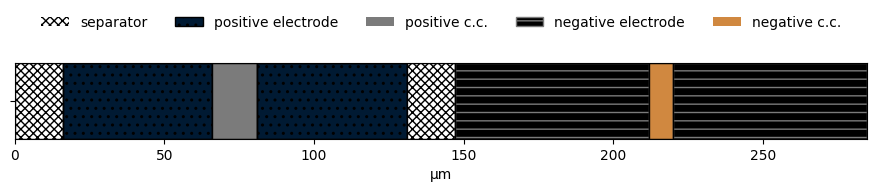

In [45]:
cell = {"cellstack": cellstack}
cell = DotMap(cell)
cell.unit = unit
plot_thickbreakdown(cell)

---
# Conclusion

* Congrats! We've successfully assembled a cell stack together with current collectors, electrode composites, separators and electrolyte
* We also looked at thicknesses, porosities, densities, and other properties that are commonly applicable in lithium-ion batteries
* Next time we will take the electrode stack sandwich, and look into winding it into an actual cylindrical battery!

**Please consider supporting Intercalation and BotB with a subscription. We'll work through some interesting case studies in the near future!**
***[Subscribe Now!](https://intercalationstation.substack.com/publish/post/%%checkout_url%%)***

